In [120]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('classic')
import numpy as np
import datetime as dt
from datetime import timedelta
import simulate
#pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.max_rows', 100)

In [121]:
spx = pd.read_csv('^GSPC.csv', index_col=0)

start = dt.date(2020, 1, 1)
end = dt.date(2080, 1, 31)


Market = simulate.Market(spx.iloc[-7500:, -2], start, end)

## Checking stability of garch model

In [122]:
empirical_mu = ((spx.iloc[-7500:, -2][-1]/spx.iloc[-7500:, -2][0])**(1/7500)-1)*100
market = Market.garch(log=False, mu_override = empirical_mu)

## Setting up functions to calculate performance

In [123]:
def determine_investment(phase, pv_u, tv_u, s, td, pi_rf, dst, g):
    
    # returns cash, new_equity, new_debt
    
    if phase == 1:
        # Check if gearing cap has been reached
        if td > tv_u:
            new_debt = 0
        else:
            new_debt = min(max(g*s, g*(pv_u-td)), dst-pv_u-s)
        return 0, s, new_debt
    
    if phase == 2: 
        stocks_sold = max(pv_u-dst, 0)
        debt_repayment = min(td, s + stocks_sold)
        leftover_savings = max(s-debt_repayment - stocks_sold, 0)
        return 0, leftover_savings, -debt_repayment
    
    if phase == 3:
        return 0, s, 0
    
    if phase == 4:
        desired_cash = (1-pi_rf)*(tv_u+s)
        desired_savings = (pi_rf)*(tv_u+s)
        change_in_stock = desired_savings - pv_u
        return desired_cash, change_in_stock, 0

In [124]:
def phase_check(phase, pi_rf, pi_rm, pi_hat, td):
    if phase == 4:
        return 4
    
    if td > 0:
        #has target not been reached?
        if pi_hat < pi_rm and phase <= 1:
            return 1
        else:
            # if target has been reached once and debt remains, stay in phase 2
            return 2
    
    #if target has been reached and no debt remains
    #is the value still above the target?
    if pi_hat < pi_rf:
        return 3
    else:
        return 4

In [125]:
def calc_pi(gamma, sigma, mr, rate, cost = 0):
    return (mr - cost - rate)/(gamma * sigma)

In [126]:
#def (gearing_cap, su, ):

## Combining with investment profile

In [127]:
def calculate_return(savings, market_returns, gearing_cap, pi_rf, pi_rm, rf, rm):
    
    # Running controls
    assert len(savings) == len(market), 'Investment plan should be same no of periods as market' 
    
    # Setting up constants and dataframe for calculation
    ses = savings.sum()     # Possibly add more sophisticated discounting
    ist = pi_rm*ses
    columns = ['period', 'savings', 'cash', 'new_equity', 'new_debt', 'total_debt', 'nip', 'pv_p', 
               'interest', 'market_returns', 'pv_u', 'tv_u', 'dst', 'phase', 'pi_hat', 'ses', 'g_hat']
    
    pp = pd.DataFrame(np.empty((len(savings), len(columns))), columns = columns)
    
    pp['ses'] = ses
    pp['period'] = range(len(savings))
    pp['market_returns'] = market_returns
    pp['savings'] = savings
    pp.loc[0, 'market_returns'] = 0
    
                      
    # Period 0 primo
    pp.loc[0, 'cash'] = 0
    pp.loc[0, 'new_equity'] = pp.loc[0, 'savings']
    pp.loc[0, 'new_debt'] = pp.loc[0, 'new_equity']*gearing_cap
    pp.loc[0, 'total_debt'] = pp.loc[0, 'new_debt']
    pp.loc[0, 'nip'] = pp.loc[0, 'new_debt'] + pp.loc[0, 'new_equity']
    pp.loc[0, 'pv_p'] = pp.loc[0, 'nip']
    pp.loc[0, 'pi_hat'] =  pp.loc[0, 'pv_p']/ses
    
    # Period 0 ultimo
    pp.loc[0, 'interest'] = pp.loc[0, 'new_debt']*rm                   
    pp.loc[0, 'pv_u'] = pp.loc[0, 'pv_p']                 
    pp.loc[0, 'tv_u'] = pp.loc[0, 'pv_u'] + pp.loc[0, 'cash']
    pp.loc[0, 'dst'] = ist
    pp.loc[0, 'phase'] = 1
    
              
    
    # Looping over all reminaning periods
    for i in range(1, len(savings)):
 
        # Period t > 0 primo
        pp.loc[i, 'cash'] = pp.loc[i-1, 'cash']*(1+rf) 
        pp.loc[i, 'cash'], pp.loc[i, 'new_equity'], pp.loc[i, 'new_debt'] = determine_investment(
                                                                                     pp.loc[i-1, 'phase'], pp.loc[i-1, 'pv_u'], 
                                                                                     pp.loc[i-1, 'tv_u'], pp.loc[i, 'savings'], pp.loc[i-1, 'total_debt'],
                                                                                     pi_rf, pp.loc[i-1, 'dst'], gearing_cap)

        pp.loc[i, 'total_debt'] = pp.loc[i-1, 'total_debt'] + pp.loc[i, 'new_debt']
        pp.loc[i, 'nip'] = pp.loc[i, 'new_equity'] + max(0, pp.loc[i, 'new_debt'])
        pp.loc[i, 'pv_p'] = pp.loc[i-1, 'pv_u'] + pp.loc[i, 'nip']        
        
        
        
        # Period t > 0 ultimo
        pp.loc[i, 'interest'] = max(pp.loc[i, 'total_debt']*rm, 0)
        pp.loc[i, 'pv_u'] = pp.loc[i, 'pv_p']*(1+pp.loc[i, 'market_returns'])-pp.loc[i, 'interest']
        pp.loc[i, 'tv_u'] = pp.loc[i, 'pv_u'] + pp.loc[i, 'cash']
        pp.loc[i, 'pi_hat'] = min(pp.loc[i, 'pv_u']/ses, pp.loc[i, 'pv_u']/pp.loc[i, 'tv_u'])
        
        pp.loc[i, 'phase'] = phase_check(pp.loc[i-1, 'phase'], pi_rf, pi_rm, pp.loc[i, 'pi_hat'], pp.loc[i, 'total_debt'])
        target_pi = pi_rm if pp.loc[i-1, 'phase'] < 3 else pi_rf
        pp.loc[i, 'dst'] = max(pp.loc[i, 'tv_u']*target_pi, ist)  # Moving stock target
        #pp.loc[i, 'dst'] = max(pp.loc[i-1, 'dst'], max(pp.loc[i, 'tv_u']*target_pi, ist))  # Locked stock target at highest previous position       
    
    pp['g_hat'] = pp['total_debt']/pp['tv_u'].abs()
    
    return pp

In [128]:
def calculate100return(savings, market_returns):
     # Running controls
    assert len(savings) == len(market), 'Investment plan should be same no of periods as market' 
    
    columns = ['period', 'savings', 'pv_p', 'market_returns', 'tv_u']
        
    pp = pd.DataFrame(np.empty((len(savings), len(columns))), columns = columns)
    
    pp['period'] = range(len(savings))
    pp['market_returns'] = market_returns
    pp['savings'] = savings
    pp.loc[0, 'market_returns'] = 0
    pp.loc[0, 'pv_p'] = pp.loc[0, 'savings']
    pp.loc[0, 'tv_u'] = pp.loc[0, 'savings']
    
    for i in range(1, len(savings)):
 
        # Period t > 0 primo
        pp.loc[i, 'pv_p'] = pp.loc[i-1, 'tv_u'] + pp.loc[i, 'savings']        
        
        # Period t > 0 ultimo
        pp.loc[i, 'tv_u'] = pp.loc[i, 'pv_p']*(1+pp.loc[i, 'market_returns'])
    
    return pp

In [129]:
def calculate9050return(savings, market_returns, rf):
    # Strategy where 90% of value is initially invested in stocks, rest in risk free asset
    # Ratio of stocks falls linearly to 50% by age 65 and stays there
    
    # Running controls
    assert len(savings) == len(market), 'Investment plan should be same no of periods as market' 
    
    columns = ['period',  'savings', 'cash', 'pv_p', 'market_returns', 'pv_u', 'tv_u', 'ratio']
        
    pp = pd.DataFrame(np.empty((len(savings), len(columns))), columns = columns)

    pp['period'] = range(len(savings))
    pp['market_returns'] = market_returns
    pp['savings'] = savings
    pp.loc[0, 'market_returns'] = 0
    pp.loc[0, 'pv_p'] = pp.loc[0, 'savings']*0.9
    pp.loc[0, 'cash'] = pp.loc[0, 'savings']*0.1
    pp.loc[0, 'pv_u'] = pp.loc[0, 'pv_p']    
    pp.loc[0, 'tv_u'] = pp.loc[0, 'savings']
    pp.loc[0, 'ratio'] = 90
    
    for i in range(1, len(savings)):
        ratio = max(90 - pp.loc[i, 'period'], 50)
        pp.loc[i, 'ratio'] = ratio
        
        # Period t > 0 primo
        pp.loc[i, 'pv_p'] = pp.loc[i-1, 'pv_u'] + pp.loc[i, 'savings']*(ratio/100)        
        pp.loc[i, 'cash'] = pp.loc[i-1, 'cash']*(1+rf) + pp.loc[i, 'savings']*(1-ratio/100)
        
        # Period t > 0 ultimo
        pp.loc[i, 'pv_u'] = pp.loc[i, 'pv_p']*(1+pp.loc[i, 'market_returns'])
        pp.loc[i, 'tv_u'] = pp.loc[i, 'pv_u'] + pp.loc[i, 'cash']
    
    return pp

In [130]:
savings_year = pd.read_csv('investment_plan_year.csv', sep=';', index_col=0)
savings_year.index = pd.to_datetime(savings_year.index, format='%Y')
savings_month = (savings_year.resample('BMS').pad()/12)['Earnings'].values
savings_year = savings_year['Earnings'].values

In [231]:
yearly_rf = 0.02
yearly_rm = 0.04  # Weighted average of margin rates

# Set period
period = 'M'


if period == 'M':
    investments = savings_month*0.05
    rf = yearly_rf/12
    rm = yearly_rm/12
    freq = 'BMS'
else:
    investments = savings_year*0.05
    rf = yearly_rf
    rm = yearly_rm
    freq = 'BYS'


gamma = 2.8
sigma = Market.yearly.pct_change().std()**2
mr = (Market.yearly[-1]/Market.yearly[0])**(1/len(Market.yearly))-1


pi_rf = calc_pi(gamma, sigma, mr, yearly_rf, cost = 0)
pi_rm = calc_pi(gamma, sigma, mr, yearly_rm, cost = 0)

print(pi_rf, pi_rm)
    
#market = Market.draw(random_state = None, freq=period).asfreq(freq, 'pad')
#market = Market.norm_innovations(random_state = 6969, freq=period).asfreq(freq, 'pad')
#market = Market.t_innovations(random_state = 6969, freq=period).asfreq(freq, 'pad')
market = Market.garch(log = False, random_state = 1000, mu_override = 0.030800266141550736).asfreq(freq, 'pad')

      
port = calculate_return(investments, market['Price'].pct_change().values, 1, pi_rf, pi_rm, rf, rm)
port100 = calculate100return(investments, market['Price'].pct_change().values)
port9050 = calculate9050return(investments, market['Price'].pct_change().values, rf)

0.7050473138793 0.45329511036871234


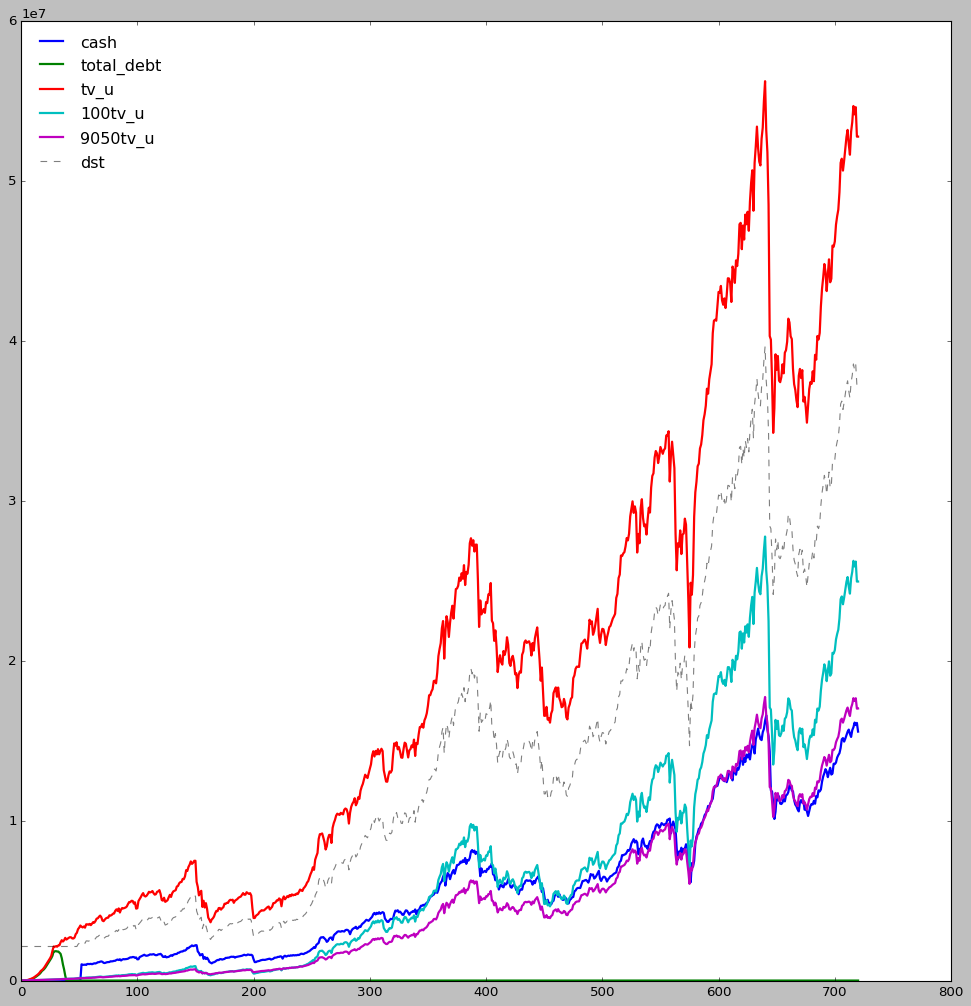

In [233]:
fig, ax = plt.subplots(1, 1, figsize = (15, 15))
vars_to_plot = ['cash', 'total_debt', 'tv_u', '100tv_u', '9050tv_u']
port['100tv_u'] = port100['tv_u']
port['9050tv_u'] = port9050['tv_u']
ax.plot(port.loc[:,vars_to_plot], linewidth = 2)
ax.plot(port.loc[:, 'dst'], linestyle="--", color="black", alpha = .5)
#ax.set_yscale('log')
vars_to_plot.append('dst')
ax.legend(vars_to_plot, loc = 'upper left', frameon=False)

(0.0, 700.0)

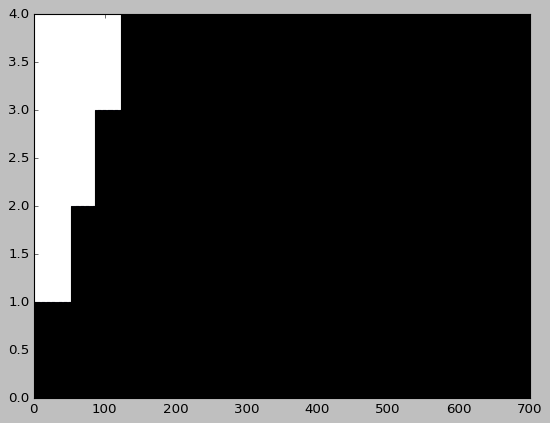

In [228]:
columns = ['period', 'savings', 'cash', 'new_equity', 'new_debt', 'total_debt', 'nip', 'pv_p', 
               'interest', 'market_returns', 'pv_u', 'tv_u', 'dst', 'phase', 'pi_hat', 'ses', 'g_hat']
    
plt.bar(x = port['period'], height = port['phase'])
plt.xlim([0, 700])

#plt.bar(x=port.loc[0:100, 'period'], height=port.loc[0:100, 'market_returns'])

## Characteristics of strategies

In [198]:
std = port.loc[:, ['tv_u', '100tv_u', '9050tv_u']].pct_change().std()

horizon = Market.years-1
mean_return = (port.loc[horizon, ['tv_u', '100tv_u', '9050tv_u']]/port.loc[0, ['tv_u', '100tv_u', '9050tv_u']])**(1/horizon)-1

In [199]:
mean_return

tv_u        0.093700
100tv_u     0.072926
9050tv_u    0.073113
dtype: float64

In [200]:
std

tv_u        0.082421
100tv_u     0.071672
9050tv_u    0.056993
dtype: float64

In [201]:
sharpe = mean_return/std

In [202]:
sharpe

tv_u        1.136853
100tv_u     1.017497
9050tv_u    1.282852
dtype: float64

# Testing many markets

In [19]:
def sim_market(seed):
    returns = []
    print(seed)
    market = Market.garch(random_state = seed).asfreq(freq, 'pad')
    port = calculate_return(investments, market['Price'].pct_change().values, 1, pi_rf, pi_rm, rf, rm)
    port100 = calculate100return(investments, market['Price'].pct_change().values)
    port9050 = calculate9050return(investments, market['Price'].pct_change().values, rf)
    port['100tv_u'] = port100['tv_u']
    port['9050tv_u'] = port9050['tv_u']
    returns.append(port.loc[Market.years-1, ['tv_u', '100tv_u', '9050tv_u']].values)
    return returns
    

In [19]:
import concurrent
from multiprocessing import Pool
yearly_rf = 0.02
yearly_rm = 0.03

# Set period
period = 'Y'


if period == 'M':
    investments = savings_month*0.05
    rf = yearly_rf/12
    rm = yearly_rm/12
    freq = 'BMS'
else:
    investments = savings_year*0.05
    rf = yearly_rf
    rm = yearly_rm
    freq = 'BYS'


gamma = 1.5
sigma = 0.20**2
mr = 0.07

pi_rf = calc_pi(gamma, sigma, mr, yearly_rf, cost = 0)
pi_rm = calc_pi(gamma, sigma, mr, yearly_rm, cost = 0)

returns = []



seeds_to_sim = list(range(100))

# multiprocessing
p = Pool()

# saving the restaurant information in a variable
res = p.apply(sim_market, seeds_to_sim)

p.close()
p.join()


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/nielseriksen/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-87e7d9e8d235>", line 39, in <module>
    res = p.apply(sim_market, seeds_to_sim)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/multiprocessing/pool.py", line 357, in apply
    return self.apply_async(func, args, kwds).get()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/multiprocessing/pool.py", line 762, in get
    self.wait(timeout)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/multiprocessing/pool.py", line 759, in wait
    self._event.wait(timeout)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/threa

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/nielseriksen/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-87e7d9e8d235>", line 39, in <module>
    res = p.apply(sim_market, seeds_to_sim)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/multiprocessing/pool.py", line 357, in apply
    return self.apply_async(func, args, kwds).get()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/multiprocessing/pool.py", line 762, in get
    self.wait(timeout)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/multiprocessing/pool.py", line 759, in wait
    self._event.wait(timeout)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/threa

TypeError: object of type 'NoneType' has no len()

In [228]:
returns = pd.DataFrame(returns, columns = ['tv_u', '100tv_u', '9050tv_u'])

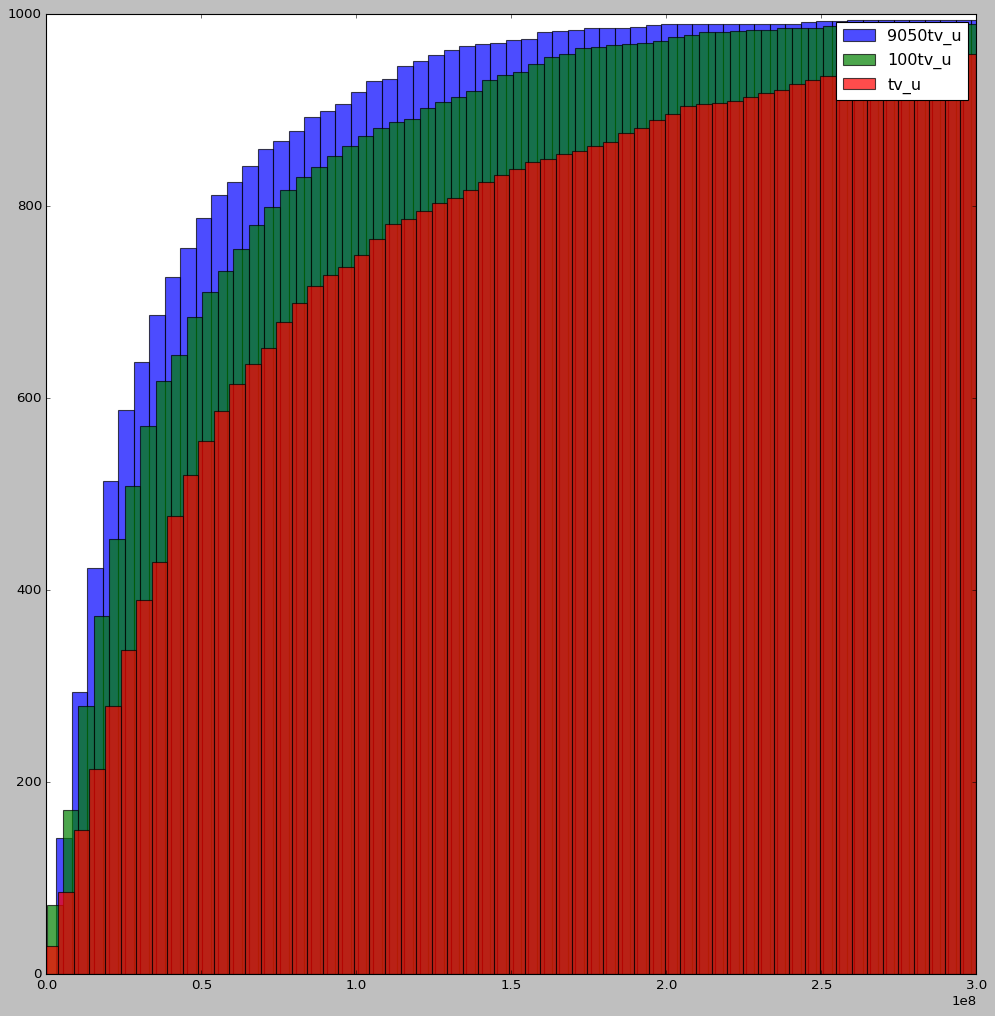

In [269]:
fig, ax = plt.subplots(1, 1, figsize = (15, 15))
vars_to_plot = ['9050tv_u', '100tv_u', 'tv_u']

bin_num = 20
cum = True
alpha = 0.7
bin_width = 5e6
max_return = 3e8

ax.hist(x = returns['9050tv_u'], bins = int(returns['9050tv_u'].max()/bin_width), cumulative = cum, alpha = alpha)
ax.hist(x = returns['100tv_u'], bins = int(returns['100tv_u'].max()/bin_width), cumulative = cum, alpha = alpha)
ax.hist(x = returns['tv_u'], bins = int(returns['tv_u'].max()/bin_width), cumulative = cum, alpha = alpha)



ax.set_xlim([0, max_return])
ax.legend(vars_to_plot)
#vars_to_plot.append('dst')
#ax.legend(vars_to_plot, loc = 'upper left', frameon=False)